# Import Libraries

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import nltk
from wordcloud import WordCloud, STOPWORDS

#Import Dataset

In [205]:
df = pd.read_csv('https://raw.githubusercontent.com/willyrizkiyan/Thomas-Cup-Sentiment/main/thomascup_2022_tweets.csv')
df.head()

# Source : https://www.kaggle.com/datasets/tejasurya/thomas-cup-2022-badminton-tweets?resource=download&select=thomascup_2022_tweets.csv

,id,text,username,hashtags,created_at,user followers count,replycount,retweetcount,likecount,quotecount,language,quotedtweet,inReplyToTweetId,inReplyToUser,mentionedUsers
0,1529235395812155392,"India has won the Thomas cup, @nikhat_zareen ...",themohanty_,"['India', 'IndianEra']",2022-05-24 22:58:24+00:00,43,0,0,3,0,en,NaN,NaN,NaN,"India has won the Thomas cup, @nikhat_zareen ..."
1,1528224948111941633,PM’s interaction with Thomas Cup Champions is ...,goikarpk,"['India', 'ThomasCup']",2022-05-22 04:03:15+00:00,51,0,0,1,0,en,NaN,NaN,NaN,PM’s interaction with Thomas Cup Champions is ...
2,1527216966171144193,India won maiden Thomas Cup after defeating 14...,BeShararat,"['ThomasCup', 'India', 'ThomasUberCup2022']",2022-05-19 09:17:53+00:00,4,0,1,1,0,en,NaN,NaN,NaN,India won maiden Thomas Cup after defeating 14...
3,1526912239910785024,#India's bunch of exceptionally proficient #Ba...,aaiprayagraj,"['India', 'Badminton', 'ThomasCup2022', 'Bangk...",2022-05-18 13:07:01+00:00,1553,0,1,1,0,en,NaN,NaN,NaN,#India's bunch of exceptionally proficient #Ba...
4,1526893293136924672,#India's bunch of exceptionally proficient #Ba...,aaisapairport,"['India', 'Badminton', 'ThomasCup2022', 'Bangk...",2022-05-18 11:51:44+00:00,1192,0,0,0,0,en,NaN,NaN,NaN,#India's bunch of exceptionally proficient #Ba...


We will use `text` column to see sentiment of Thomas Cup 2022.

# Check Info Dataset

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    9704 non-null   int64  
 1   text                  9704 non-null   object 
 2   username              9704 non-null   object 
 3   hashtags              9680 non-null   object 
 4   created_at            9704 non-null   object 
 5   user followers count  9704 non-null   int64  
 6   replycount            9704 non-null   int64  
 7   retweetcount          9704 non-null   int64  
 8   likecount             9704 non-null   int64  
 9   quotecount            9704 non-null   int64  
 10  language              9704 non-null   object 
 11  quotedtweet           0 non-null      float64
 12  inReplyToTweetId      1174 non-null   float64
 13  inReplyToUser         1174 non-null   object 
 14  mentionedUsers        9704 non-null   object 
dtypes: float64(2), int64(

There are 9704 data in `text` column.

# Cleaning up errors and special symbols

In [207]:
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = " ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
df["text"] = df["text"].apply(clean)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Calculate the sentiment scores

In [208]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
df["Positive"] = [sia.polarity_scores(i)["pos"] for i in df["text"]]
df["Negative"] = [sia.polarity_scores(i)["neg"] for i in df["text"]]
df["Neutral"] = [sia.polarity_scores(i)["neu"] for i in df["text"]]
df["Compound"] = [sia.polarity_scores(i)["compound"] for i in df["text"]]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [209]:
df = df[["text", "Positive", 
             "Negative", "Neutral", "Compound"]]
df.head()

,text,Positive,Negative,Neutral,Compound
0,india thoma cup nikhatzareen gold end joint ...,0.128,0.085,0.787,0.3182
1,pm interact thoma cup champion amaz simpl yet ...,0.140,0.000,0.860,0.5994
2,india maiden thoma cup defeat champion indone...,0.342,0.094,0.564,0.8360
3,india bunch except profici badminton player li...,0.312,0.000,0.688,0.8271
4,india bunch except profici badminton player li...,0.312,0.000,0.688,0.8271


# Assign Label

In [210]:
def sentiment(post):
    if sia.polarity_scores(post)["compound"] >= 0.05:
        return "Positive"
    elif sia.polarity_scores(post)["compound"] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [211]:
df['sentiment'] = df['text'].apply(lambda x: sentiment(x))

In [212]:
df['sentiment'].value_counts()

Neutral     5142
Positive    4147
Negative     415
Name: sentiment, dtype: int64

In [213]:
df.head()

,text,Positive,Negative,Neutral,Compound,sentiment
0,india thoma cup nikhatzareen gold end joint ...,0.128,0.085,0.787,0.3182,Positive
1,pm interact thoma cup champion amaz simpl yet ...,0.140,0.000,0.860,0.5994,Positive
2,india maiden thoma cup defeat champion indone...,0.342,0.094,0.564,0.8360,Positive
3,india bunch except profici badminton player li...,0.312,0.000,0.688,0.8271,Positive
4,india bunch except profici badminton player li...,0.312,0.000,0.688,0.8271,Positive


Most of opinions are neutral or positive. Just a little bit of negative sentiment.

# Word Cloud

In [214]:
def show_wordcloud(df, title=""):
    text = " ".join(t for t in df.dropna())
    stopwords = set(STOPWORDS)
    stopwords.update(["t", "co", "https", "amp", "U", "Badminton" "India", "Thomascup", "Thomas", "india", "thomas", "cup", "badminton", "indonesia"])
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=50, max_words=500,background_color="black").generate(text)
    fig = plt.figure(1, figsize=(16,16))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

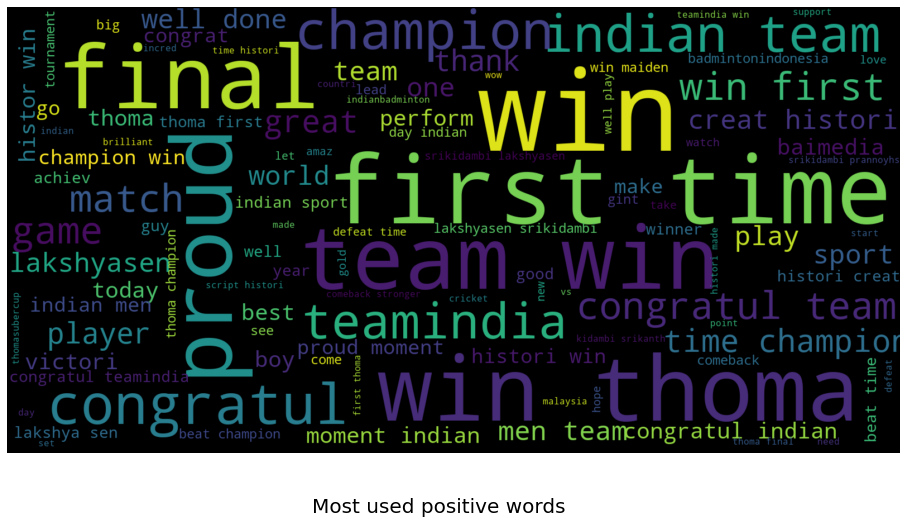

In [215]:
show_wordcloud(df.loc[(df['sentiment']=="Positive"), 'text'], title = 'Most used positive words')